In [3]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam,SGD
import keras
import matplotlib.pyplot as plt
import sys
import numpy as np
import os



In [4]:
from os import listdir, makedirs
from os.path import join, exists, expanduser

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
datasets_dir = join(cache_dir, 'datasets') # /cifar-10-batches-py
if not exists(datasets_dir):
    makedirs(datasets_dir)


!cp ../input/cifar-10-python.tar.gz ~/.keras/datasets/
!ln -s  ~/.keras/datasets/cifar-10-python.tar.gz ~/.keras/datasets/cifar-10-batches-py.tar.gz
!tar xzvf ~/.keras/datasets/cifar-10-python.tar.gz -C ~/.keras/datasets/

cp: cannot stat '../input/cifar-10-python.tar.gz': No such file or directory
tar (child): /home/datalore/.keras/datasets/cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [5]:
# Load CIFAR10 data
(X_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select a single class images (birds)
X_train = X_train[y_train.flatten() == 2]

170508288/170498071 [==============================] - 11s 0us/step


In [6]:
# Input shape
img_rows = 32
img_cols = 32
channels = 3
        
img_shape = (img_rows, img_cols, channels)        
latent_dim = 100

In [7]:
def build_generator():

        model = Sequential()

        model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
        model.add(Reshape((8, 8, 128)))
        
        model.add(UpSampling2D())#upsamples to 16*16*128
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(UpSampling2D()) #upsamples to 32*32*128
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        model.add(Conv2D(channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        #outputs an image of 32*32*3

        noise = Input(shape=(latent_dim,))
        img = model(noise)

        return Model(noise, img)

In [8]:
def build_discriminator():

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        #no normalization for the first layer 
        
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

In [9]:
# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.0002,0.5),
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))

In [10]:
def show_imgs(epoch):
        r, c = 4,4
        noise = np.random.normal(0, 1, (r * c,latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

In [11]:
def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()
    plt.show()

0 [D loss: 1.163901] [G loss: 0.718379]


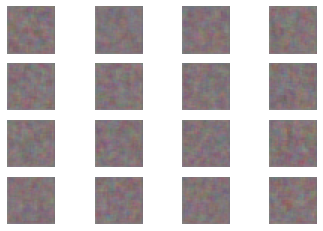

In [ ]:
epochs=30000
batch_size=32
display_interval=5000
losses=[]

#normalizing the input
X_train = X_train / 127.5 - 1.
        

        # Adversarial ground truths
valid = np.ones((batch_size, 1))
        #let's add some noise 
valid += 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)

for epoch in range(epochs):

            
            #  Train Discriminator
            

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            gen_imgs = generator.predict(noise)
            

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            
            #  Train Generator
            

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = combined.train_on_batch(noise, valid)
            
            # Plot the progress
            if epoch % 5000==0:
                print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
            if epoch % 1000==0:
                losses.append((d_loss[0],g_loss))
                
            if epoch % display_interval == 0:
                 show_imgs(epoch)

In [ ]:
show_losses(losses)

In [ ]:
s=X_train[:40]
s = 0.5 * s + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(s):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()

In [ ]:
noise = np.random.normal(size=(40, latent_dim))
generated_images = generator.predict(noise)
generated_images = 0.5 * generated_images + 0.5
f, ax = plt.subplots(5,8, figsize=(16,10))
for i, img in enumerate(generated_images):
        ax[i//8, i%8].imshow(img)
        ax[i//8, i%8].axis('off')
        
plt.show()